In [1]:
import sys
sys.executable

'/home/ubuntu-system/miniconda3/envs/hrviton/bin/python'

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [3]:
import argparse
import numpy as np
import torchgeometry
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms

from PIL import Image
from torchvision.utils import save_image
from torchvision.utils import make_grid as make_image_grid

In [4]:
sys.path.append("..")

In [5]:
from networks import (
    ConditionGenerator, 
    load_checkpoint, 
    make_grid
)

from cp_dataset_test import (
    CPDatasetTest,
    CPDataLoader
)

In [6]:
class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
        return tensor

In [7]:
def get_opt():
    parser = argparse.ArgumentParser()

    parser.add_argument("--gpu_ids", default="")
    parser.add_argument('-j', '--workers', type=int, default=4)
    parser.add_argument('-b', '--batch-size', type=int, default=1)
    parser.add_argument('--fp16', action='store_true', help='use amp')
    # Cuda availability
    parser.add_argument('--cuda',default=False, help='cuda or cpu')

    parser.add_argument('--test_name', type=str, default='test', help='test name')
    parser.add_argument("--dataroot", default="./data/zalando-hd-resize")
    parser.add_argument("--datamode", default="test")
    parser.add_argument("--data_list", default="test_pairs.txt")
    parser.add_argument("--output_dir", type=str, default="./Output")
    parser.add_argument("--datasetting", default="unpaired")
    parser.add_argument("--fine_width", type=int, default=768)
    parser.add_argument("--fine_height", type=int, default=1024)

    parser.add_argument('--tensorboard_dir', type=str, default='./data/zalando-hd-resize/tensorboard', help='save tensorboard infos')
    parser.add_argument('--checkpoint_dir', type=str, default='checkpoints', help='save checkpoint infos')
    parser.add_argument('--tocg_checkpoint', type=str, default='./eval_models/weights/v0.1/mtviton.pth', help='tocg checkpoint')
    parser.add_argument('--gen_checkpoint', type=str, default='./eval_models/weights/v0.1/gen.pth', help='G checkpoint')

    parser.add_argument("--tensorboard_count", type=int, default=100)
    parser.add_argument("--shuffle", action='store_true', help='shuffle input data')
    parser.add_argument("--semantic_nc", type=int, default=13)
    parser.add_argument("--output_nc", type=int, default=13)
    parser.add_argument('--gen_semantic_nc', type=int, default=7, help='# of input label classes without unknown class')
    
    # network
    parser.add_argument("--warp_feature", choices=['encoder', 'T1'], default="T1")
    parser.add_argument("--out_layer", choices=['relu', 'conv'], default="relu")
    
    # training
    parser.add_argument("--clothmask_composition", type=str, choices=['no_composition', 'detach', 'warp_grad'], default='warp_grad')
        
    # Hyper-parameters
    parser.add_argument('--upsample', type=str, default='bilinear', choices=['nearest', 'bilinear'])
    parser.add_argument('--occlusion', action='store_true', help="Occlusion handling")

    # generator
    parser.add_argument('--norm_G', type=str, default='spectralaliasinstance', help='instance normalization or batch normalization')
    parser.add_argument('--ngf', type=int, default=64, help='# of gen filters in first conv layer')
    parser.add_argument('--init_type', type=str, default='xavier', help='network initialization [normal|xavier|kaiming|orthogonal]')
    parser.add_argument('--init_variance', type=float, default=0.02, help='variance of the initialization distribution')
    parser.add_argument('--num_upsampling_layers', choices=('normal', 'more', 'most'), default='most', # normal: 256, more: 512
                        help="If 'more', adds upsampling layer between the two middle resnet blocks. If 'most', also add one more upsampling + resnet layer at the end of the generator")

    opt = parser.parse_args(args=[])
    return opt

def remove_overlap(seg_out, warped_cm):
    assert len(warped_cm.shape) == 4
    warped_cm = warped_cm - (torch.cat([seg_out[:, 1:3, :, :], seg_out[:, 5:, :, :]], dim=1)).sum(dim=1, keepdim=True) * warped_cm
    return warped_cm

opt = get_opt()

In [8]:
opt.cuda = True
opt.occlusion = True
opt.tocg_checkpoint = "../pretrained/mtviton.pth"
opt.dataroot = "../data"
opt.data_list = "test_pairs.txt"

In [9]:
device = "cuda" if opt.cuda else "cpu"

In [10]:
tocg = ConditionGenerator(
    opt,
    input1_nc=4,
    input2_nc=opt.semantic_nc + 3,
    output_nc=opt.output_nc,
    ngf=96,
    norm_layer=nn.BatchNorm2d
).to(device)

load_checkpoint(tocg, opt.tocg_checkpoint, opt)

gauss = torchgeometry.image.GaussianBlur((15, 15), (3, 3)).to(device)

In [11]:
test_dataset = CPDatasetTest(opt)
test_loader = CPDataLoader(opt, test_dataset)

/home/ubuntu-system/miniconda3/envs/hrviton/lib/python3.9/site-packages/torchvision/transforms/transforms.py:280: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(
/home/ubuntu-system/miniconda3/envs/hrviton/lib/python3.9/site-packages/torchvision/transforms/transforms.py:280: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(
/home/ubuntu-system/miniconda3/envs/hrviton/lib/python3.9/site-packages/torchvision/transforms/transforms.py:280: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(
/home/ubuntu-system/miniconda3/envs/hrviton/lib/python3.9/site-packages/torchvision/transforms/transforms.py:280: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enu

In [16]:
from typing import Tuple

@torch.no_grad()
def get_warped_image(
    clothes: torch.Tensor, 
    pre_clothes_mask: torch.Tensor, 
    parse_agnostic: torch.Tensor, 
    densepose: torch.Tensor
) -> Tuple[torch.Tensor, torch.Tensor]:

    pre_clothes_mask_down = F.interpolate(pre_clothes_mask, size=(256, 192), mode='nearest')
    input_parse_agnostic_down = F.interpolate(parse_agnostic, size=(256, 192), mode='nearest')
    agnostic_down = F.interpolate(agnostic, size=(256, 192), mode='nearest')
    clothes_down = F.interpolate(clothes, size=(256, 192), mode='bilinear')
    densepose_down = F.interpolate(densepose, size=(256, 192), mode='bilinear')
    
    input1 = torch.cat([clothes_down, pre_clothes_mask_down], 1)
    input2 = torch.cat([input_parse_agnostic_down, densepose_down], 1)

    flow_list, fake_segmap, warped_cloth_paired, warped_clothmask_paired = tocg(opt,input1, input2)
            
    warped_cm_onehot = torch.FloatTensor((warped_clothmask_paired.detach().cpu().numpy() > 0.5).astype(np.float)).to(device)

    cloth_mask = torch.ones_like(fake_segmap)
    cloth_mask[:,3:4, :, :] = warped_clothmask_paired
    fake_segmap = fake_segmap * cloth_mask
                    
    fake_parse_gauss = gauss(F.interpolate(fake_segmap, size=(opt.fine_height, opt.fine_width), mode='bilinear'))

    N, _, iH, iW = clothes.shape
    flow = F.interpolate(flow_list[-1].permute(0, 3, 1, 2), size=(iH, iW), mode='bilinear').permute(0, 2, 3, 1)
    flow_norm = torch.cat([flow[:, :, :, 0:1] / ((96 - 1.0) / 2.0), flow[:, :, :, 1:2] / ((128 - 1.0) / 2.0)], 3)
            
    grid = make_grid(N, iH, iW,opt).to(device)
    warped_grid = grid + flow_norm
    warped_cloth = F.grid_sample(clothes, warped_grid, padding_mode='border')
    warped_clothmask = F.grid_sample(pre_clothes_mask, warped_grid, padding_mode='border')
    
    warped_clothmask = remove_overlap(F.softmax(fake_parse_gauss, dim=1), warped_clothmask)
    warped_cloth = warped_cloth * warped_clothmask + torch.ones_like(warped_cloth) * (1-warped_clothmask)   

    return warped_cloth, warped_clothmask
         
vis_transform = transforms.Compose([
    UnNormalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)), 
    transforms.ToPILImage()
])


/tmp/ipykernel_134205/1656795569.py:12: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pre_clothes_mask = torch.FloatTensor((pre_clothes_mask.detach().cpu().numpy() > 0.5).astype(np.float)).cuda()
/tmp/ipykernel_134205/2703447193.py:23: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  warped_cm_onehot = torch.FloatTensor((warped_clothmask_pai

torch.Size([1, 3, 1024, 768]) torch.Size([1, 1, 1024, 768]) torch.Size([1, 13, 1024, 768]) torch.Size([1, 3, 1024, 768])


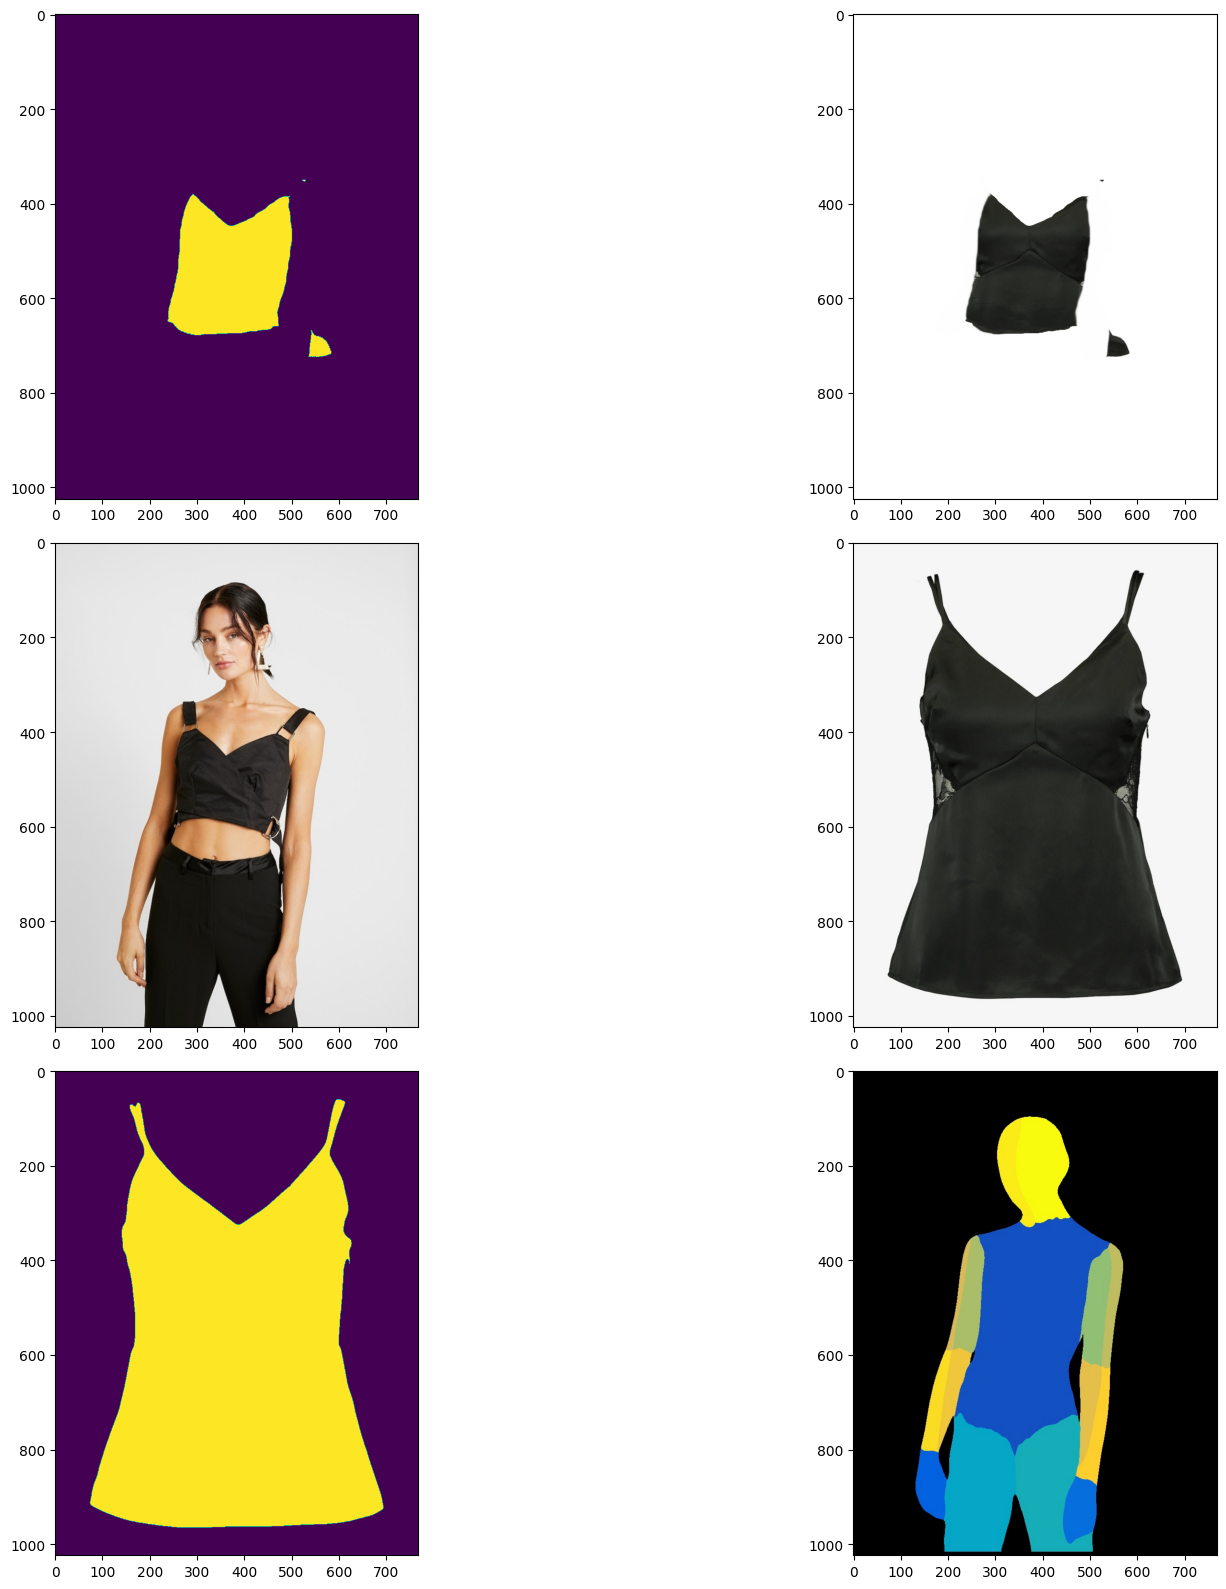

torch.Size([1, 3, 1024, 768]) torch.Size([1, 1, 1024, 768]) torch.Size([1, 13, 1024, 768]) torch.Size([1, 3, 1024, 768])


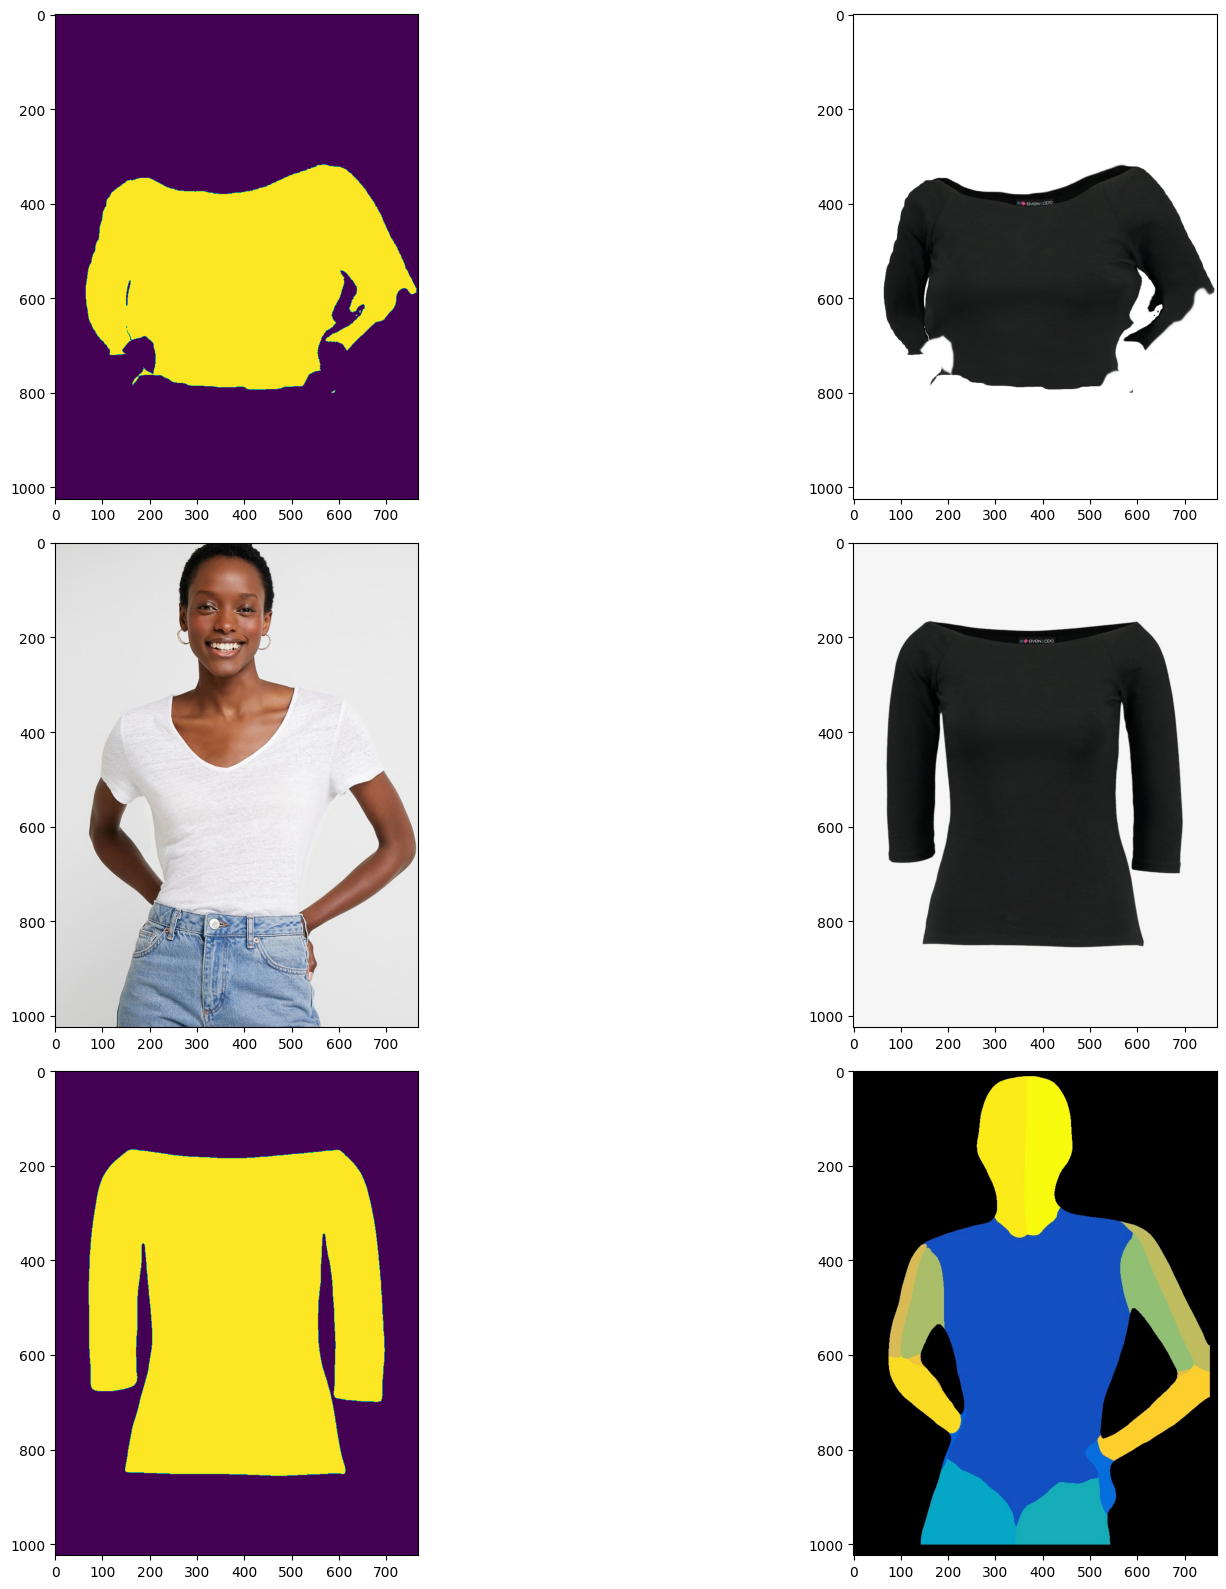

torch.Size([1, 3, 1024, 768]) torch.Size([1, 1, 1024, 768]) torch.Size([1, 13, 1024, 768]) torch.Size([1, 3, 1024, 768])


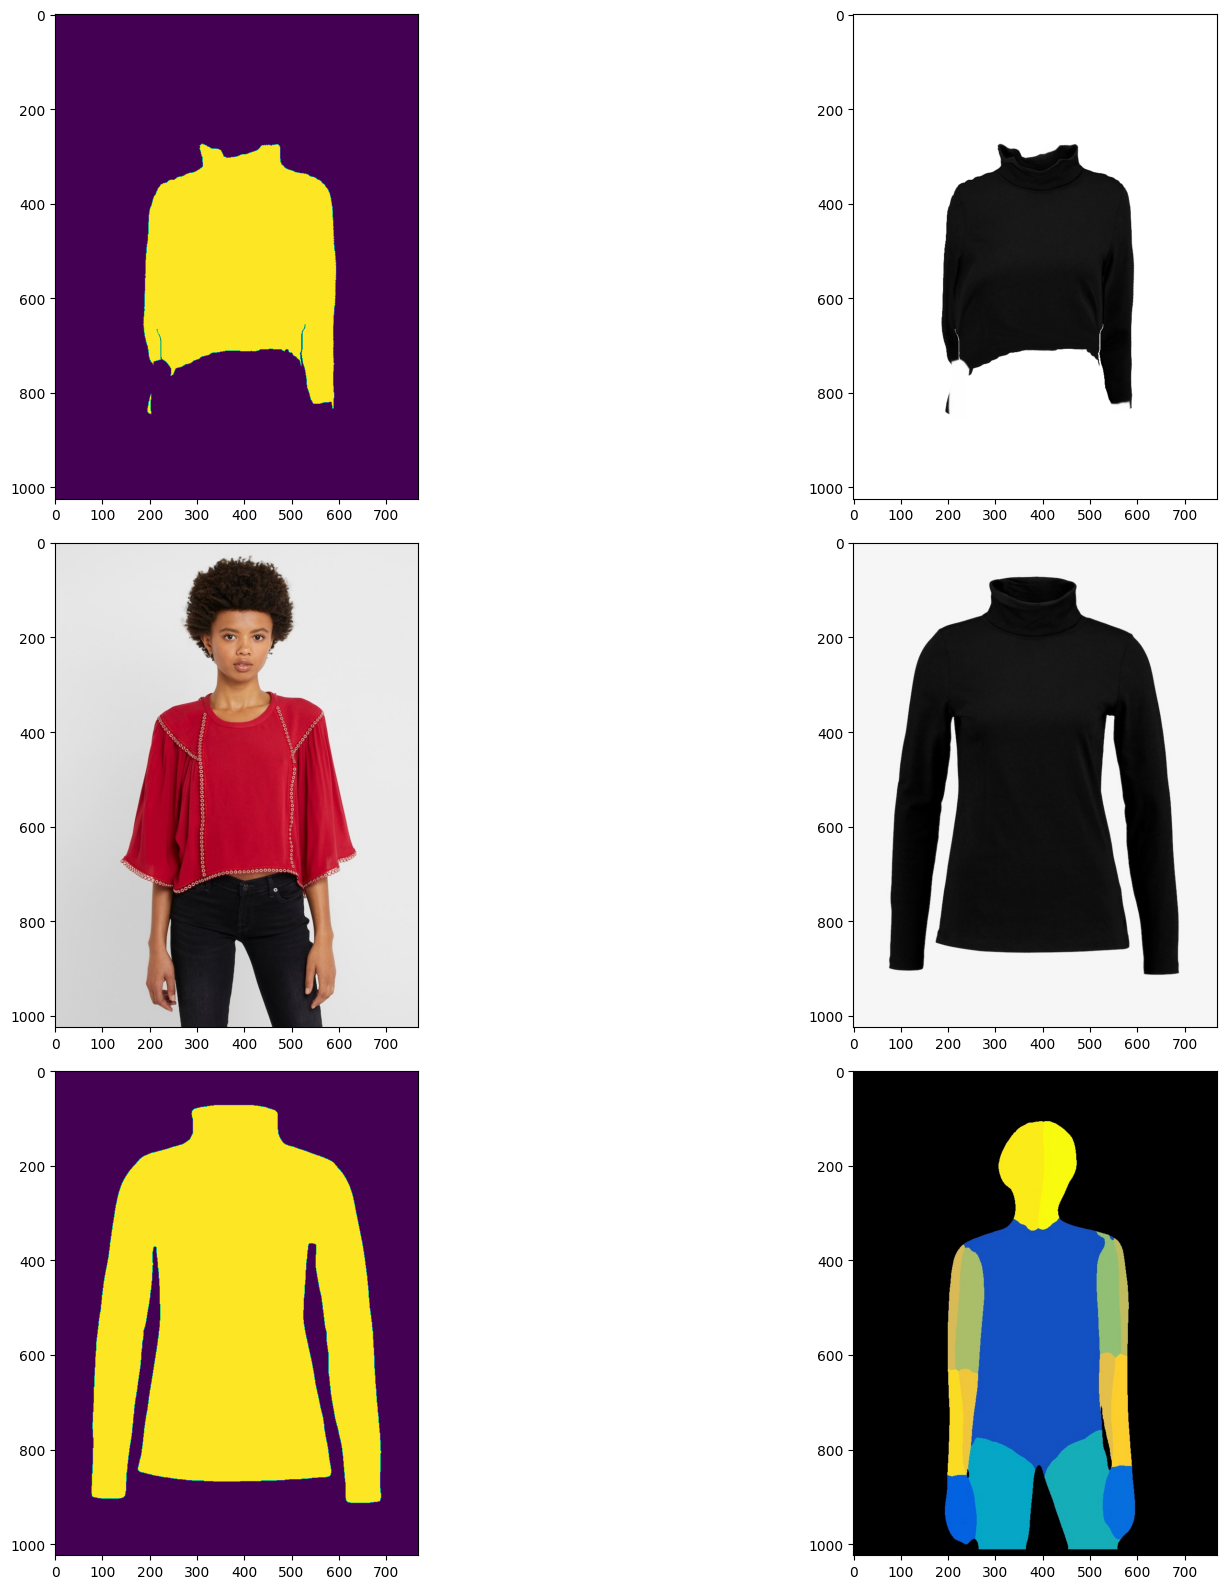

torch.Size([1, 3, 1024, 768]) torch.Size([1, 1, 1024, 768]) torch.Size([1, 13, 1024, 768]) torch.Size([1, 3, 1024, 768])


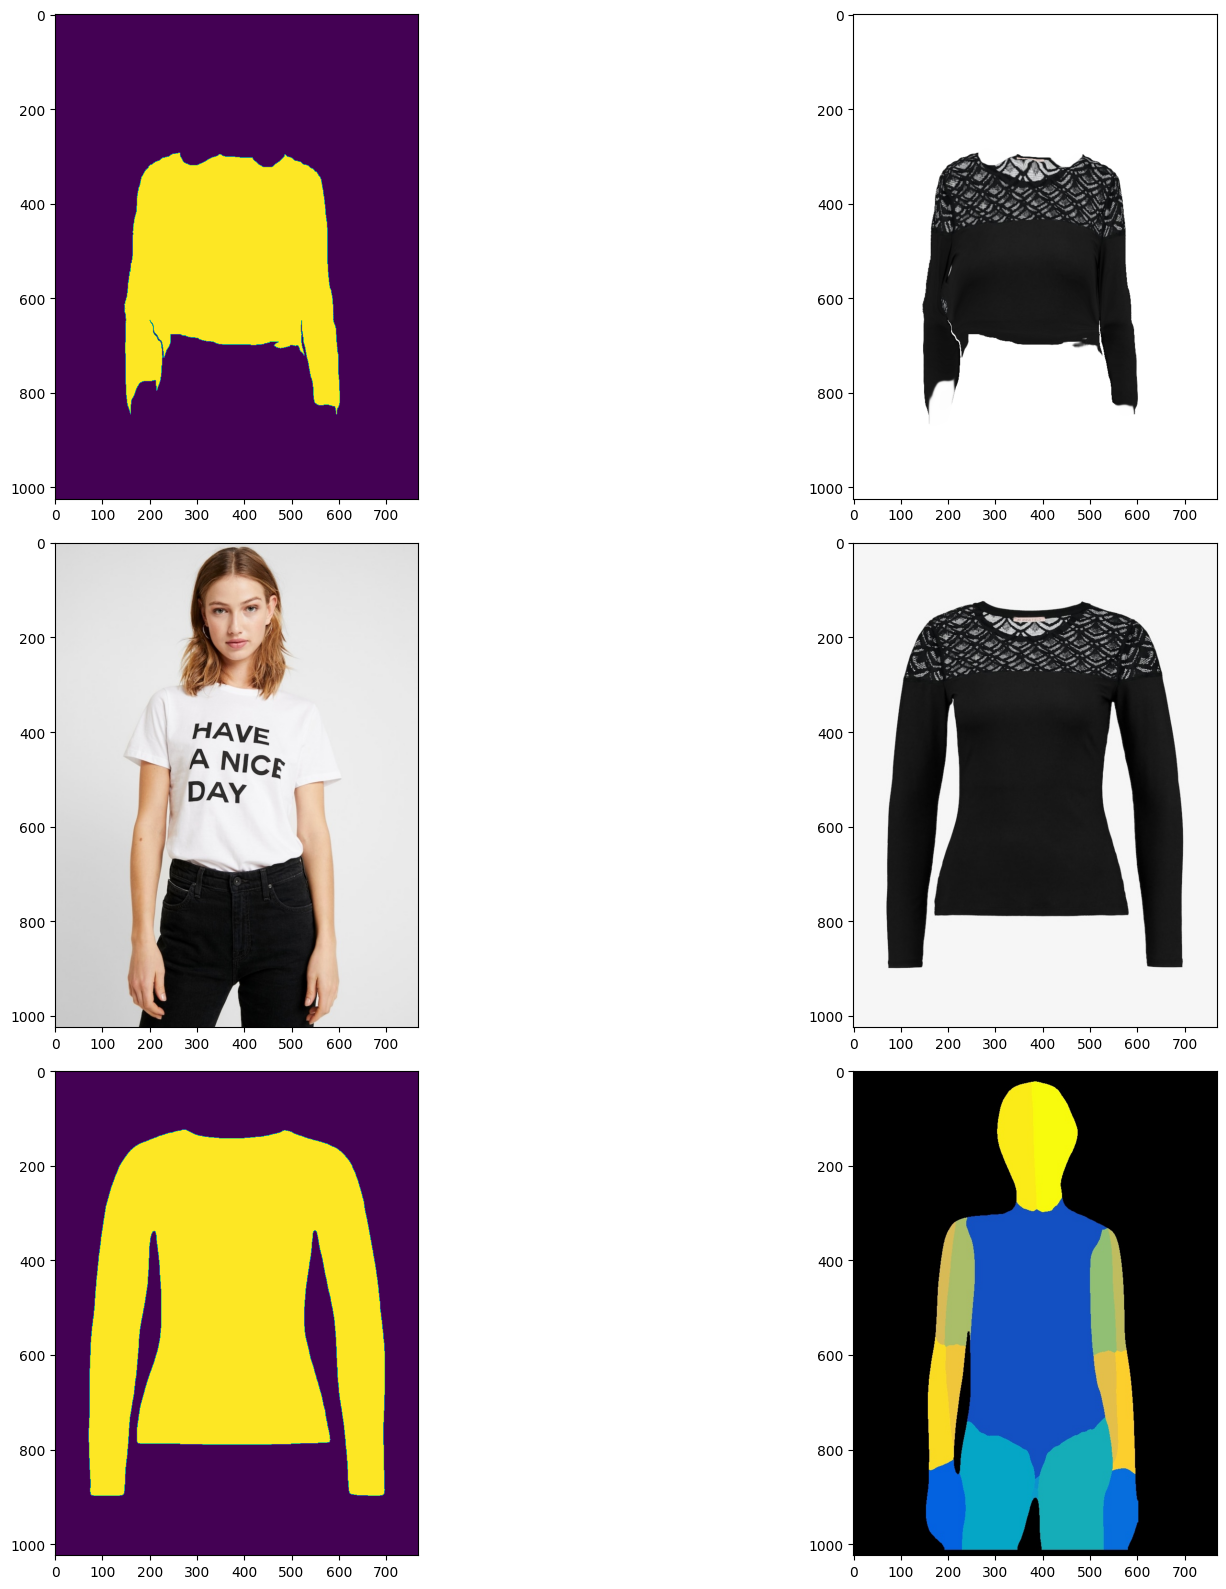

torch.Size([1, 3, 1024, 768]) torch.Size([1, 1, 1024, 768]) torch.Size([1, 13, 1024, 768]) torch.Size([1, 3, 1024, 768])


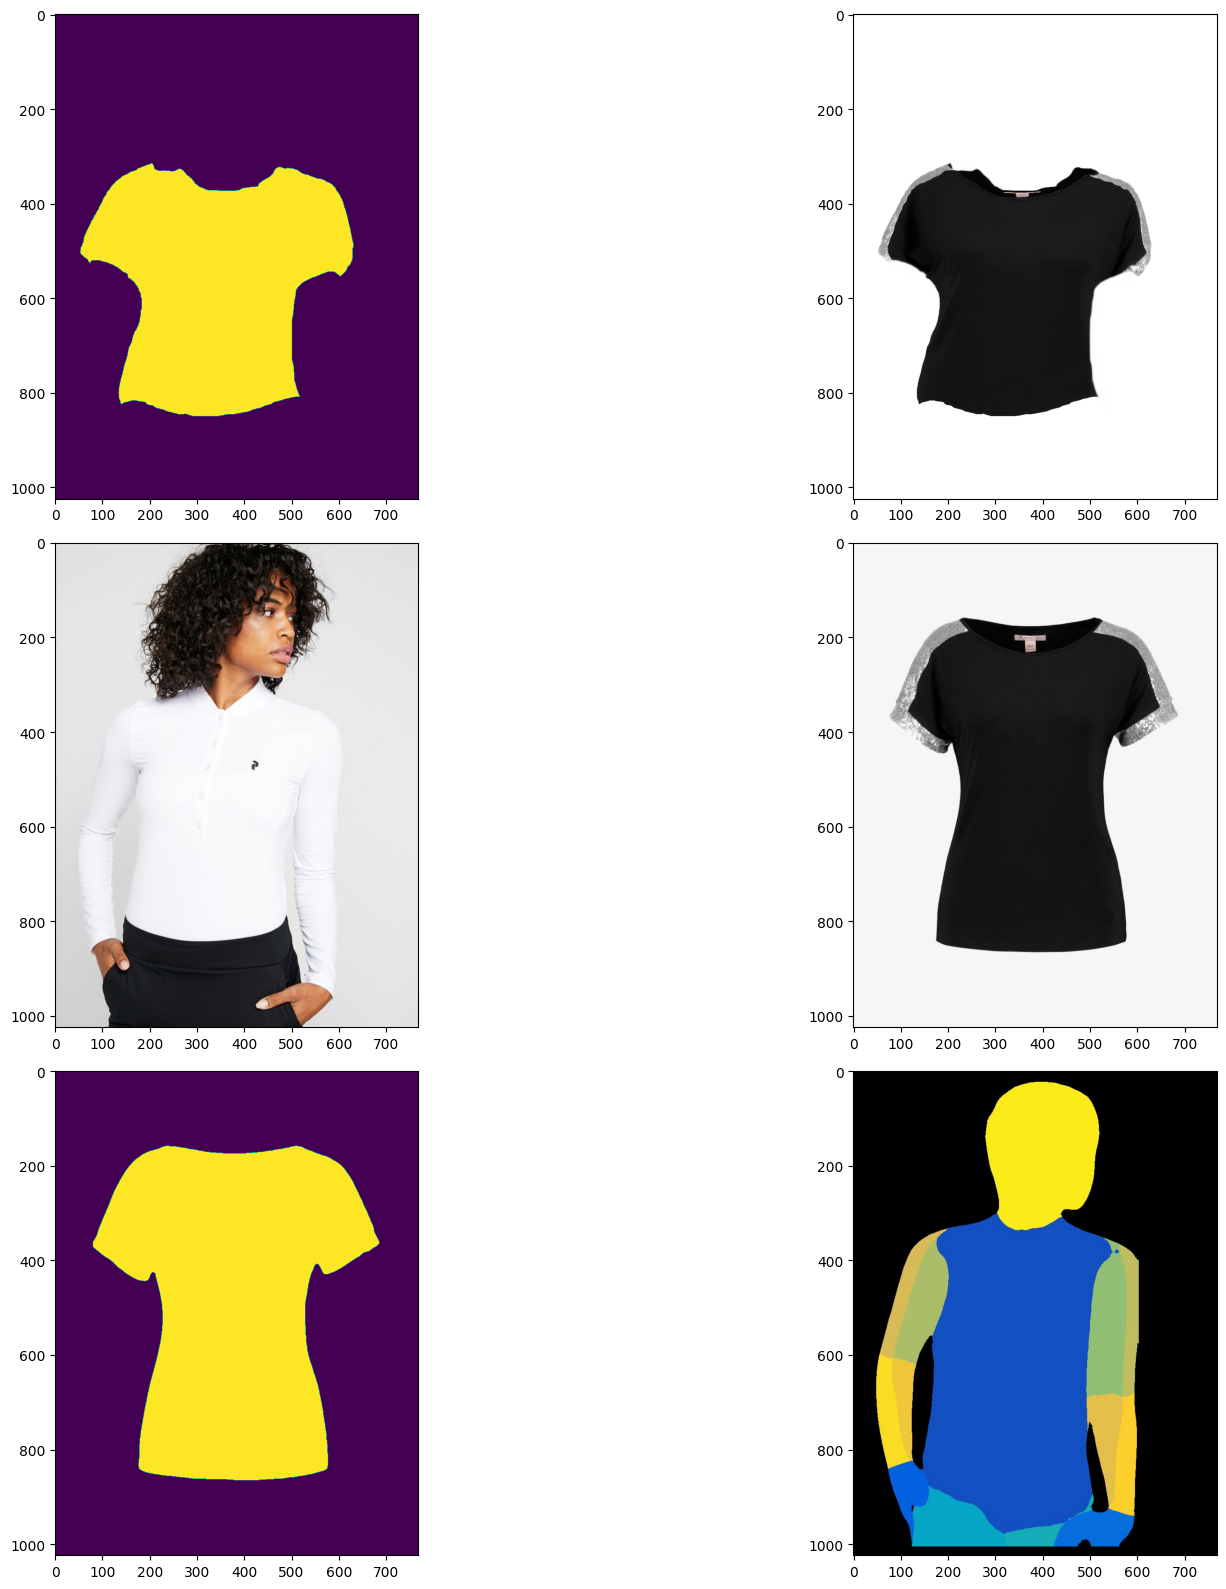

In [17]:
for i in range(5):
    inputs = test_loader.next_batch()
    pose_map = inputs['pose'].cuda()
    pre_clothes_mask = inputs['cloth_mask'][opt.datasetting].cuda()
    label = inputs['parse']
    parse_agnostic = inputs['parse_agnostic']
    agnostic = inputs['agnostic'].cuda()
    clothes = inputs['cloth'][opt.datasetting].cuda() # target cloth
    densepose = inputs['densepose'].cuda()
    im = inputs['image']
    input_label, input_parse_agnostic = label.cuda(), parse_agnostic.cuda()
    pre_clothes_mask = torch.FloatTensor((pre_clothes_mask.detach().cpu().numpy() > 0.5).astype(np.float)).cuda()
    
    warped_cloth, warped_clothmask = get_warped_image(
        clothes, pre_clothes_mask,
        input_parse_agnostic, densepose
    )
        
    warped_clothmask, warped_cloth = warped_clothmask.cpu(), warped_cloth.cpu()
    
#     fig, ax = plt.subplots(1, 2, figsize=(20, 16))
#     ax[0].imshow(flow_norm[0, :, :, 0].detach().cpu())
#     ax[1].imshow(flow_norm[0, :, :, 1].detach().cpu())
#     plt.show()
    
    fig, ax = plt.subplots(3, 2, figsize=(20, 16))
    ax[0][0].imshow(warped_clothmask[0, 0].round())
    ax[0][1].imshow(vis_transform(warped_cloth[0].clone()))
    ax[1][0].imshow(vis_transform(im[0].clone()))
    ax[1][1].imshow(vis_transform(clothes[0].clone()))
    ax[2][0].imshow(vis_transform(pre_clothes_mask[0].clone()))
    ax[2][1].imshow(vis_transform(densepose[0].clone()))
    plt.tight_layout()
    plt.show()
